# Convergence Analysis of Monte Carlo and quasi Monte Carlo methods (coupled with incremental, PCA, and Brownian bridge construction) for the pricing of geometric Asian call options.

In [15]:
# Imports:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Import helper functions for MC/RQMC methods, GBM path generation, and asian option payoffs:
import lds, paths, asian  

## Geometric Asian Call Options

We perform a convergence analysis for the **standard Monte Carlo approximation technique** and some **quasi Monte Carlo techniques** for pricing general **multi-look (path-dependent) exotic options**.  

Specifically, we focus on the **geometric Asian call option**, which, given:

- Spot price: $S_0$ at initial time $t_0 = 0$
- Monitoring times: $\{ t_1, \ldots, t_d = T \}$
- Strike price: $K$
- Asset dynamics: $S_t$ following a GBM with interest rate $r$ and volatility $\sigma$

has the payoff:

$$
\max\{ G_T - K, 0 \}, \quad \text{where} \quad G_T = \left( \prod_{i=1}^d S_{t_i} \right)^{1/d}.
$$

-----

We choose this type of option for the convergence analysis since, in this setting, we can evaluate its (discounted) fair price **in closed form**, assuming equidistant monitoring times $t_i = iT/d$:

$$
e^{-rT} \, \mathbb{E}\big[\max\{ G_T - K, 0\}\big]
= e^{-rT} \left[ S_0 e^{\mu_d T} \Phi(d_1) - K \Phi(d_2) \right],
$$

where:

$$
\begin{aligned}
\sigma_d^2 &= \frac{\sigma^2 (d + 1)(2d + 1)}{6d^2}, \\[6pt]
\mu_d &= \left( r - \frac{1}{2}\sigma^2 \right)\frac{d + 1}{2d} + \frac{1}{2}\sigma_d^2, \\[6pt]
d_1 &= \frac{\ln(S_0/K) + (\mu_d + \tfrac{1}{2}\sigma_d^2)T}{\sigma_d \sqrt{T}}, \\[6pt]
d_2 &= d_1 - \sigma_d \sqrt{T}.
\end{aligned}
$$


In [16]:
# Experiment parameters:
S0, K, r, sigma, T = 100.0, 100.0, 0.02, 0.20, 1.0  # market/contract params: 
d_steps_list = [20,100,1000,2000]         # trading days
d_steps = d_steps_list[0]
n_list  = [2**5, 2**6 ,2**7, 2**8, 2**9, 2**10, 2**11, 2**12]  # simulated paths per replicate
R_list  = [4, 16, 32]                              # RQMC replicates to try
BASE_SEED = 123                                     # fixed seed


# Closed-form (discrete) geometric-Asian *call* price (exclude S0 from average)
true_geom = asian.geometric_asian_call_price_discrete(S0 = S0, K=K, r=r, sigma=sigma, T=T, d=d_steps)
print(f"Discounted fair price in closed form for geometric Asian call option: {true_geom}")

Discounted fair price in closed form for geometric Asian call option: 5.059740636394133


## Simulation Methods for Convergence Analysis

Next, we introduce the functions used in our analysis to implement:

---

### **1. Monte Carlo Simulation**

This means that we build the GBM paths by sampling independently normally distributed points  
$Z_i \sim \mathcal{N}(0,1)$ and then follow the standard incremental construction:

$$
W_{t_{i+1}} - W_{t_i} = \sqrt{t_{i+1} - t_i} \, Z_i,
$$

in order to get

$$
S_{t_{i+1}} = S_{t_i} \exp \left[ \left(r - \tfrac{1}{2}\sigma^2\right)(t_{i+1} - t_i) + \sigma (W_{t_{i+1}} - W_{t_i}) \right].
$$

---

### **2. Sobol Points for Quasi Monte Carlo Simulation**

In the Monte Carlo (MC) method, the samples $Z_1, \ldots, Z_d$ are obtained by first sampling  
$(U_1, \ldots, U_d)$ uniformly from the distribution on $[0,1]^d$ (i.e., $U_i$ are independent) and then applying the inverse transform method:

$$
Z_i = \Phi^{-1}(U_i).
$$

The quasi Monte Carlo (QMC) methods we consider here, instead of sampling $U_1, \ldots, U_d$ independently, use **deterministic Sobol low-discrepancy sequences** of points in $[0,1]^d$.  
These sequences cover the domain more evenly, leading to **faster convergence** as the number of simulations $n$ increases compared to the MC method.

The use of Sobol points can be exploited even further with constructions such that the first points (low frequencies) in the sequence determine most of the GBM path constructed.  
We explore the following two methods to do so:

---

### **3. PCA (Principal Component Analysis)**

The Brownian motion vector  
$W = [W_{t_1}, \ldots, W_{t_d}]$ yielding a GBM can be constructed as

$$
W = A Z,
$$

where $Z \sim \mathcal{N}(0, I_d)$ and $A A^\top = \Sigma$, with  
$\Sigma_{i,j} = \text{Cov}(W_{t_i}, W_{t_j})= \min(t_i,t_j)$.

Solving for $A$ using **Cholesky factorization** yields the same incremental construction as above.  
However, the **PCA method** finds

$$
A = P \Lambda^{1/2},
$$

from the eigendecomposition

$$
\Sigma = P \Lambda P^\top.
$$

---

### **4. Brownian Bridge Construction**

This method sets up the GBM path using **Brownian bridges** in a recursive bisection fashion.  
More precisely, we start with

$$
W_{t_0} = 0, \quad W_{t_d} = \sqrt{T} Z_1,
$$

and then continue bisecting recursively until all grid points are filled by the conditional construction:

$$
W_{t_{\text{mid}}} \mid W_{t_{\text{left}}}, W_{t_{\text{right}}}
\sim 
\frac{t_{\text{right}} - t_{\text{mid}}}{t_{\text{right}} - t_{\text{left}}} W_{t_{\text{left}}}
+ 
\frac{t_{\text{mid}} - t_{\text{left}}}{t_{\text{right}} - t_{\text{left}}} W_{t_{\text{right}}}
+ 
\sqrt{ \frac{(t_{\text{right}} - t_{\text{mid}})(t_{\text{mid}} - t_{\text{left}})}{t_{\text{right}} - t_{\text{left}}} } \, Z_i.
$$


In [17]:

methods = ['standard', 'bridge', 'pca']

def estimate_geom_price_MC(n_paths: int, seed: int, pre: dict, d_steps: int, T: float) -> tuple[float, float, float]:
    """
    Classic MC baseline (PRNs), standard increments.
    Returns (mean price, SE, elapsed_pre_pay)
    where elapsed_pre_pay is the time from function call until 'pay' is computed.
    """
    t0 = time.perf_counter()

    Z = lds.prn_normals(n_paths, d_steps, seed=seed)
    S = paths.generate_paths('standard', S0, r, sigma, T, d_steps, Z, precomp=pre)
    pay = asian.asian_payoff_paths(S, K, r, T, option='call', average='geom')

    elapsed_pre_pay = time.perf_counter() - t0

    mean = float(np.mean(pay))
    se = float(np.std(pay, ddof=1) / np.sqrt(len(pay))) if len(pay) > 1 else 0.0

    return mean, se, elapsed_pre_pay

def estimate_geom_price_QMC(method: str, n_paths: int, seed: int, pre: dict, d_steps: int, T: float) -> tuple[float,float]:
    """
    Single scrambled QMC replicate (R=1) for a given path method.
    Returns the price estimate (no CI with a single replicate).
    """
    t0 = time.perf_counter()

    Z = lds.sobol_normal_replicates(n=n_paths, d=d_steps, R=1,
                                    base_seed=seed, use_base2=False)[0]
    S = paths.generate_paths(method, S0, r, sigma, T, d_steps, Z, precomp=pre)
    pay = asian.asian_payoff_paths(S, K, r, T, option='call', average='geom')

    elapsed_pre_pay = time.perf_counter() - t0

    return float(np.mean(pay)), elapsed_pre_pay


def estimate_geom_price_RQMC_with_stats(method: str, n_paths: int, R: int, base_seed: int, pre: dict, d_steps: int, T: float) -> tuple[float, float, list[float], float]:
    """
    RQMC with R independent scramblings.
    Returns (mean across replicates, SE across replicates, list of replicate means).
    SE is sqrt(Var(replicate_means)/R).
    """
    t0 = time.perf_counter()

    Z_reps = lds.sobol_normal_replicates(n=n_paths, d=d_steps, R=R,
                                         base_seed=base_seed, use_base2=False)
    means = []
    for Z in Z_reps:
        S = paths.generate_paths(method, S0, r, sigma, T, d_steps, Z, precomp=pre)
        pay = asian.asian_payoff_paths(S, K, r, T, option='call', average='geom')
        means.append(float(np.mean(pay)))
    means = np.asarray(means, dtype=float)
    mean = float(means.mean())

    elapsed_pre_pay = time.perf_counter() - t0

    var_reps = float(means.var(ddof=1)) if len(means) > 1 else 0.0
    se = float(np.sqrt(var_reps / len(means))) if len(means) > 1 else 0.0
    return mean, se, means.tolist(), elapsed_pre_pay

### **Comparison of Convergence Methods**

Then, we compare the **convergence behavior**, as the number of simulations $n$ increases, of the following approaches for constructing GBM paths:

- **Vanilla Monte Carlo (MC) with standard incremental construction**
- **QMC with standard incremental construction**
- **QMC with PCA-based construction**
- **QMC with Brownian Bridge construction**


Discounted fair price in closed form for geometric Asian call option: 5.059740636394133


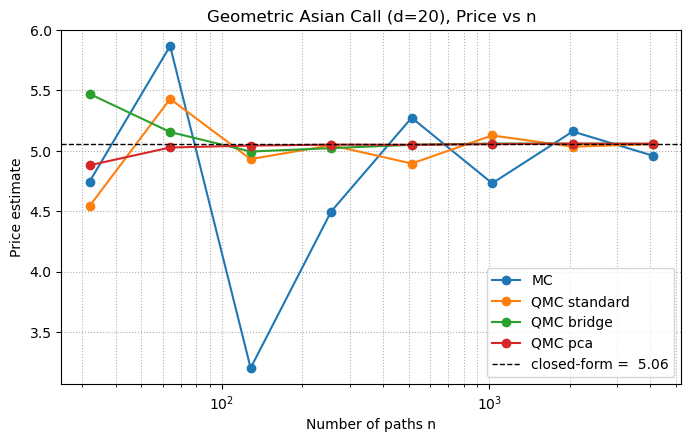

In [18]:
print(f"Discounted fair price in closed form for geometric Asian call option: {true_geom}")
# Precompute once per grid for the path builders
pre = paths.precompute_all(T, d_steps)

mc_means, mc_ses, mc_times = [], [], []
qmc_means = {m: [] for m in methods}

for i, n in enumerate(n_list):
    mean_mc, se_mc, time_mc = estimate_geom_price_MC(n_paths=n, seed=BASE_SEED + i, pre = pre, d_steps = d_steps, T = T)
    mc_means.append(mean_mc)
    mc_ses.append(se_mc)
    for m in methods:
        mean_qmc, time_qmc = estimate_geom_price_QMC(m, n_paths=n, seed=BASE_SEED + i, pre = pre, d_steps = d_steps, T = T)
        qmc_means[m].append(mean_qmc)

plt.figure(figsize=(8,4.6))
x = np.array(n_list, dtype=float)


plt.semilogx(n_list, mc_means, marker='o', label='MC')
# QMC R=1 (no CI bars)
for m in methods:
    plt.semilogx(n_list, qmc_means[m], marker='o', label= "QMC " + m)

# Truth as horizontal line
plt.axhline(true_geom, linestyle='--', linewidth=1, label= f'closed-form = {true_geom: .2f}', color = "black")

plt.xlabel('Number of paths n')
plt.ylabel('Price estimate')
plt.title(f'Geometric Asian Call (d={d_steps}), Price vs n')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

### **Convergence and Computational Efficiency**

As shown in the figure above, the **quasi Monte Carlo (QMC)** methods converge to **more accurate approximations** at a faster rate.

Next, we evaluate how the **computational time** required by each method scales as the **number of monitoring times** $d$ increases.


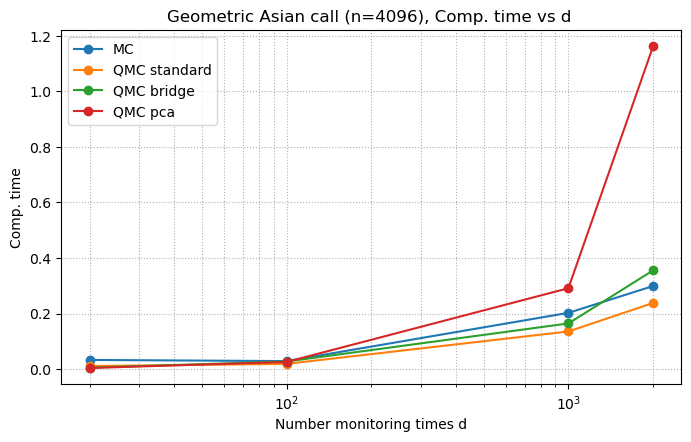

In [19]:
mc_times = []
qmc_times = {m: [] for m in methods}

n_fixed = n_list[-1]

for i, d in enumerate(d_steps_list):
    _, _, time_mc = estimate_geom_price_MC(n_paths=n_fixed, seed=BASE_SEED + i, pre = None, d_steps = d, T = T)
    mc_times.append(time_mc)
    for m in methods:
        _, time_qmc = estimate_geom_price_QMC(m, n_paths=n_fixed, seed=BASE_SEED + i, pre = None, d_steps = d, T = T)
        qmc_times[m].append(time_qmc)

plt.figure(figsize=(8,4.6))
plt.semilogx(d_steps_list, mc_times, marker='o', label='MC')
for m in methods:
    plt.semilogx(d_steps_list, qmc_times[m], marker='o', label= "QMC " + m)


plt.xlabel('Number monitoring times d')
plt.ylabel('Comp. time')
plt.title(f'Geometric Asian call (n={n_fixed}), Comp. time vs d ')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.show()

## Discussion of Computational Performance and Convergence

As shown in the figure above, the **PCA method** tends to become **very expensive** as the number of monitoring times increases.

In contrast, the **Brownian Bridge** construction is **only slightly more computationally expensive** than the standard Monte Carlo (MC) method,  
while **converging faster** to more accurate estimates.

---

### **Scrambled Quasi Monte Carlo Methods**

We recall that the **quasi Monte Carlo (QMC)** methods used are **deterministic**.  
To obtain an **unbiased estimator** for which we can also compute **error estimates** we *scramble* the points in the Sobol sequences.

This is achieved using **Owen scrambling** (or **digital shift**, if selected).  
For each scrambling, we record the mean and standard deviation of the results obtained from different **scrambled permutations** (replicates $R$).

---

### **Visualization and Interpretation**

In the graphs below, we plot, **for fixed dimension $d$ and as a function of the number of simulations $n$**,  
the **mean** and **standard deviation** of the replicated ($R = 4, 16, 32$) quasi Monte Carlo methods,  
together with **95% confidence intervals** for each case.


Discounted fair price in closed form for geometric Asian call option: 15.300604011774343


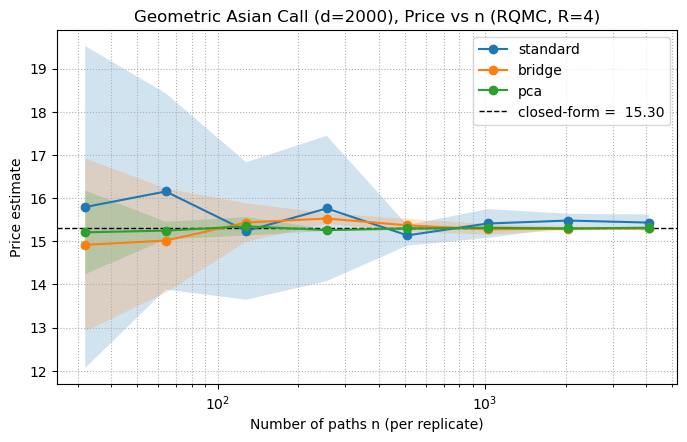

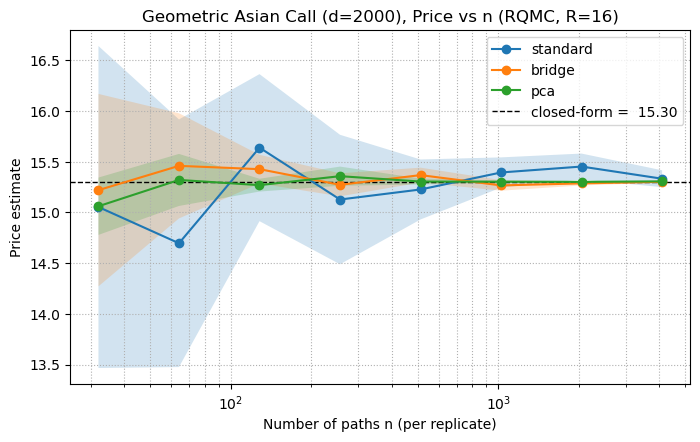

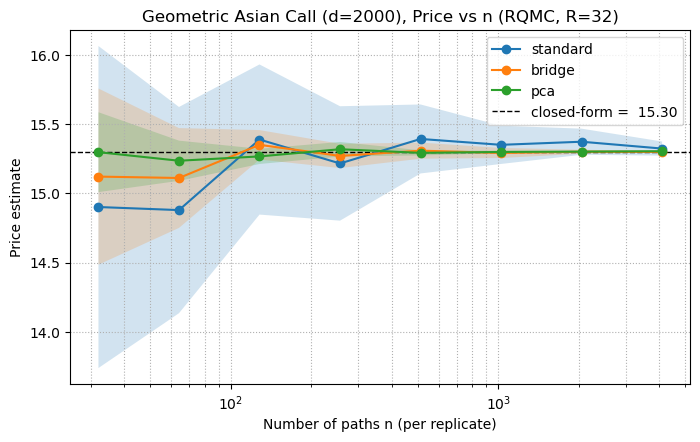

In [20]:
T = 10.0
d_steps = 2000

true_geom = asian.geometric_asian_call_price_discrete(S0 = S0, K=K, r=r, sigma=sigma, T=T, d=d_steps)
print(f"Discounted fair price in closed form for geometric Asian call option: {true_geom}")

pre = paths.precompute_all(T, d_steps)

for R in R_list:
    means = {m: [] for m in methods}
    ses   = {m: [] for m in methods}

    for i, n in enumerate(n_list):
        for m in methods:
            mean_m, se_m, _, qmc_time = estimate_geom_price_RQMC_with_stats(
                method=m, n_paths=n, R=R, base_seed=BASE_SEED + 1000+ i*10, pre = pre, d_steps = d_steps, T = T
            )
            means[m].append(mean_m)
            ses[m].append(se_m)

    plt.figure(figsize=(8,4.6))
    x = np.array(n_list, dtype=float)

    # for m in methods:
    #     plt.errorbar(x, means[m], yerr=1.96*np.array(ses[m]), fmt='-o', capsize=3, label=m, alpha=0.85)

    for m in methods:
        y = np.asarray(means[m])
        e = 1.96 * np.asarray(ses[m])
        plt.plot(x, y, '-o', label=m, zorder=3)
        plt.fill_between(x, y - e, y + e, alpha=0.2)  

    plt.axhline(true_geom, linestyle='--', linewidth=1, label= f'closed-form = {true_geom: .2f}', color = "black")

    plt.xscale('log')
    plt.xlabel('Number of paths n (per replicate)')
    plt.ylabel('Price estimate')
    plt.title(f'Geometric Asian Call (d={d_steps}), Price vs n (RQMC, R={R})')
    plt.grid(True, which='both', ls=':')
    plt.legend()
    plt.show()



We also summarize in a table, the mean, standard deviation, and computational time values for the last $n$ plotted above.

In [21]:
n_star = n_list[-1]
rows = []

# MC at n_star
mc_mean, mc_se, mc_time = estimate_geom_price_MC(n_paths=n_star, seed=BASE_SEED + 1040, pre = None, d_steps = d_steps, T = T)
rows.append({'Method':'MC (standard)', 'R':1, 'n': n_star,
            'price': mc_mean, 'SE': mc_se, 'Time': mc_time})

# QMC (R=1)
for m in methods:
    mean1, time1 = estimate_geom_price_QMC(m, n_paths=n_star, seed=BASE_SEED + 1040, pre = None, d_steps = d_steps, T = T)
    rows.append({'Method':f'QMC {m}', 'R':1, 'n': n_star,
                'price': mean1, 'SE': np.nan, "Time": time1})

# RQMC
for m in methods:
    for R in R_list:
        meanR, seR, _ , timeR= estimate_geom_price_RQMC_with_stats(
            method=m, n_paths=n_star, R=R, base_seed=BASE_SEED + 1040, pre = None, d_steps = d_steps, T = T
        )
        rows.append({'Method':f'RQMC {m}', 'R':R, 'n': n_star,
                    'price': meanR, 'SE': seR, "Time": timeR})

df_summary = pd.DataFrame(rows)
df_summary


,Method,R,n,price,SE,Time
0,MC (standard),1,4096,15.245642,0.394447,0.258728
1,QMC standard,1,4096,15.388732,NaN,0.252661
2,QMC bridge,1,4096,15.305943,NaN,0.377276
3,QMC pca,1,4096,15.292518,NaN,1.145975
4,RQMC standard,4,4096,15.366885,0.012795,1.042441
5,RQMC standard,16,4096,15.302802,0.026693,4.027173
6,RQMC standard,32,4096,15.313480,0.021727,8.052813
7,RQMC bridge,4,4096,15.307349,0.013010,1.498838
8,RQMC bridge,16,4096,15.305363,0.004745,6.031653
9,RQMC bridge,32,4096,15.299129,0.003035,12.340226


### **Conclusions**

From this analysis, we can draw the following conclusions:

- **Quasi Monte Carlo (QMC)** methods using **low-frequency Sobol points** converge **faster** (as the number of simulations $n$ increases) to accurate solutions than standard Monte Carlo (MC) methods.  
- The **PCA method** is the **slowest**, but it yields the **most accurate** and **least noisy** RQMC estimates.  
- The **best trade-off** between computational efficiency and accuracy in our experiments is achieved by the **Brownian Bridge construction** combined with **low-discrepancy Sobol points**.
